# 🩺 Chest X-ray Pneumonia Classification using DenseNet121

This project implements a **Deep Learning pipeline** for classifying chest X-ray images into **Normal** and **Pneumonia** categories using **DenseNet121** with transfer learning.  
The model is trained and evaluated on the popular [Chest X-ray Pneumonia dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

---

## 📂 Dataset
The dataset is organized into three subsets:
- **Train:** Used for model training with data augmentation and class balancing.  
- **Validation:** Used for model selection and hyperparameter tuning.  
- **Test:** Final evaluation of the trained model.  

Class distribution (example from training set):
- **NORMAL:** 1341  
- **PNEUMONIA:** 3875  

To handle imbalance:
- Used **WeightedRandomSampler**  
- Applied **pos_weight** in loss function  

---

## ⚙️ Model Architecture
- **Base Model:** Pretrained DenseNet121 (`torchvision.models.densenet121`)  
- **Head:** Fully connected layer with single logit output for binary classification  
- **Loss:** `BCEWithLogitsLoss` with class weights  
- **Optimizer:** `AdamW` with weight decay  
- **Scheduler:** `OneCycleLR`  

---

## 🧪 Training Details
- **Batch Size:** 32  
- **Epochs:** 10  
- **Transforms (Augmentations):**  
  - Random Resized Crop  
  - Random Rotation (±15°)  
  - Color Jitter (Brightness)  
  - Normalization (ImageNet mean/std)  

---

## 📊 Results
Best model performance:

- **Validation Accuracy (best epoch):** ~0.94  
- **Test Accuracy:** **0.9071**  
- **Test AUROC:** **0.9716**  
- **Best Threshold:** 0.9836  

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ===============================
# Paths
# ===============================
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [3]:
# ===============================
# Count classes
# ===============================
train_dataset_raw = datasets.ImageFolder(train_dir)
normal_count = len([x for x in train_dataset_raw.imgs if x[1] == 0])
pneumonia_count = len([x for x in train_dataset_raw.imgs if x[1] == 1])
print(f"Class counts - NORMAL: {normal_count}, PNEUMONIA: {pneumonia_count}")

# For BCEWithLogitsLoss (pos_weight = negatives / positives)
pos_weight = torch.tensor([normal_count / pneumonia_count])
print(f"Using pos_weight: {pos_weight.item():.4f}")

Class counts - NORMAL: 1341, PNEUMONIA: 3875
Using pos_weight: 0.3461


In [4]:
# ===============================
# Transforms
# ===============================
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [5]:
# ===============================
# Datasets & Sampler
# ===============================
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Weighted sampler to balance classes
class_counts = [normal_count, pneumonia_count]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for _, label in train_dataset.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

classes = train_dataset.classes
print(f"Classes: {classes}")

Classes: ['NORMAL', 'PNEUMONIA']


In [6]:
# ===============================
# Device & Model (DenseNet121)
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained DenseNet121
model = models.densenet121(pretrained=True)
# Replace classifier head
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 1)  # binary classification (logit output)
model = model.to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 152MB/s] 


In [7]:
# ===============================
# Loss, Optimizer, Scheduler
# ===============================
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, 
                                          steps_per_epoch=len(train_loader), epochs=10)


In [8]:
# ===============================
# Evaluation Function
# ===============================
def evaluate_model(loader, is_test=False, threshold=0.5, return_details=False):
    model.eval()
    true_labels, pred_labels, pred_probs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            preds = (probs > threshold).astype(int)
            
            true_labels.extend(labels.numpy())
            pred_labels.extend(preds)
            pred_probs.extend(probs)
    
    acc = accuracy_score(true_labels, pred_labels)
    auc = roc_auc_score(true_labels, pred_probs)
    cm = confusion_matrix(true_labels, pred_labels)
    
    if is_test:
        print(f"Test Accuracy: {acc:.4f}")
        print(f"Test AUROC: {auc:.4f}")
        print("Confusion Matrix:")
        print(cm)
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()
    
    if return_details:
        return acc, auc, cm, np.array(true_labels), np.array(pred_probs)
    else:
        return acc, auc, cm

In [9]:
# ===============================
# Training Function
# ===============================
def train_model(num_epochs=10):
    best_val_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
        val_acc, _, _ = evaluate_model(val_loader)
        print(f"Validation Accuracy: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
    
    print("Training complete.")

In [10]:
# ===============================
# Train
# ===============================
train_model(num_epochs=10)

# Load best model
model.load_state_dict(torch.load("best_model.pth"))

Epoch [1/10], Loss: 0.1157
Validation Accuracy: 0.6875
Epoch [2/10], Loss: 0.0491
Validation Accuracy: 0.8125
Epoch [3/10], Loss: 0.0346
Validation Accuracy: 0.6250
Epoch [4/10], Loss: 0.0277
Validation Accuracy: 0.9375
Epoch [5/10], Loss: 0.0247
Validation Accuracy: 0.6875
Epoch [6/10], Loss: 0.0219
Validation Accuracy: 0.7500
Epoch [7/10], Loss: 0.0189
Validation Accuracy: 0.6250
Epoch [8/10], Loss: 0.0133
Validation Accuracy: 0.6250
Epoch [9/10], Loss: 0.0134
Validation Accuracy: 0.8125
Epoch [10/10], Loss: 0.0161
Validation Accuracy: 0.6250
Training complete.


<All keys matched successfully>

Best threshold: 0.9836
Test Accuracy: 0.9071
Test AUROC: 0.9716
Confusion Matrix:
[[221  13]
 [ 45 345]]


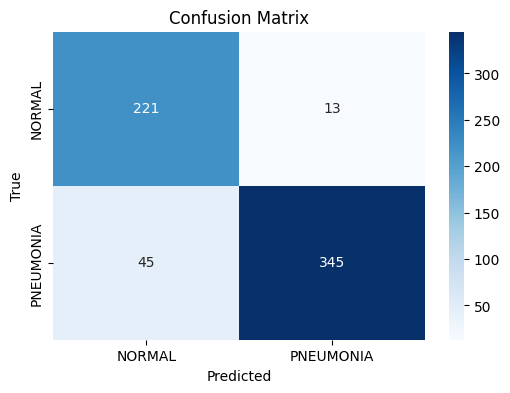

(0.907051282051282,
 0.9715647600262984,
 array([[221,  13],
        [ 45, 345]]))

In [11]:
# ===============================
# Find Best Threshold from Validation
# ===============================
_, _, _, val_true, val_probs = evaluate_model(val_loader, return_details=True)
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
best_threshold = thresholds[np.argmax(tpr - fpr)]
print(f"Best threshold: {best_threshold:.4f}")

# ===============================
# Test with Best Threshold
# ===============================
evaluate_model(test_loader, is_test=True, threshold=best_threshold)